In [11]:
# Keep this cell while WIP
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import jax.random as jrd
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.math.psd_kernels as tfk
from liesel.goose.optim import Stopper, history_to_df

from batram.tmspat_jax.model import TransformationModel
from batram.tmspat_jax.node import (
    OnionCoefPredictivePointProcessGP,
    OnionKnots,
    ModelVar,
    GEVLocation
)

key = jrd.PRNGKey(42)
k1, k2 = jrd.split(key)

In [13]:
loc_true = 2.0
scale_true = 1.5
concentration_true = 0.7
gev = tfd.GeneralizedExtremeValue(loc=loc_true, scale=scale_true, concentration=concentration_true)
y = gev.sample(sample_shape=(90, 100), seed=k1)

In [14]:
locs = jrd.uniform(key, shape=(y.shape[1], 2))
knots = OnionKnots(-3.0, 3.0, nparam=12)
locs_var = lsl.Var(locs, name="locs")

coef = OnionCoefPredictivePointProcessGP.new_from_locs(
    knots,
    inducing_locs=lsl.Var(locs[:-50, :], name="inducing_locs"),
    sample_locs=locs_var,
    kernel_cls=tfk.ExponentiatedQuadratic,
    amplitude=lsl.param(1.0, name="amplitude"),
    length_scale=lsl.param(1.0, name="length_scale"),
    name="coef",
)


# loc = ModelVar(0.0, name="loc")
scale = ModelVar(1.0, bijector=tfb.Softplus(), name="scale")
concentration = ModelVar(0.3, name="concentration")
loc = GEVLocation(0.0, scale=scale, concentration=concentration, data=y, name="loc")

model = TransformationModel(
    y[:-50, :],
    knots=knots.knots,
    coef=coef,
    loc=loc,
    scale=scale,
    concentration=concentration,
    parametric_distribution=tfd.GeneralizedExtremeValue,
)

/Users/johannesbrachem/Documents/git/batram-jb /src/batram/tmspat_jax/node.py:127: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  self.eps = jnp.array(eps, dtype=jnp.float64)


In [15]:
stopper = Stopper(max_iter=1000, patience=20)

result = model.fit_parametric_distributionloc_batched(
    train=y,
    validation=y,
    locs=locs_var,
    stopper=stopper
)

Training loss: 22196.486, Validation loss: 22196.486:  64%|██████▍   | 643/999 [00:06<00:02, 171.11it/s]

In [16]:
result.position

{'concentration_transformed': Array(0.670258, dtype=float32),
 'loc_unclipped': Array(2.028009, dtype=float32),
 'scale_transformed': Array(1.2906097, dtype=float32)}

<Axes: xlabel='iteration'>

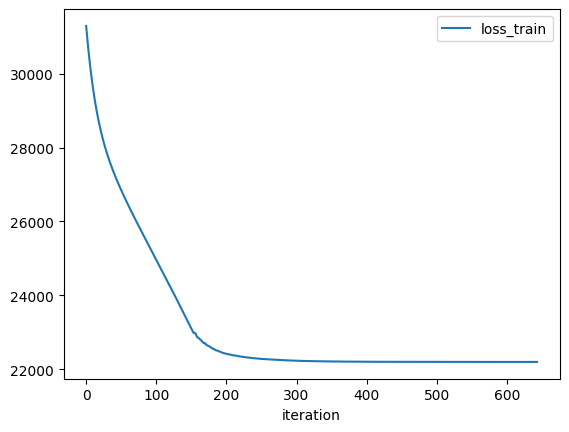

In [17]:
history_to_df(result.history)[["loss_train", "iteration"]].plot("iteration")

<Axes: xlabel='iteration'>

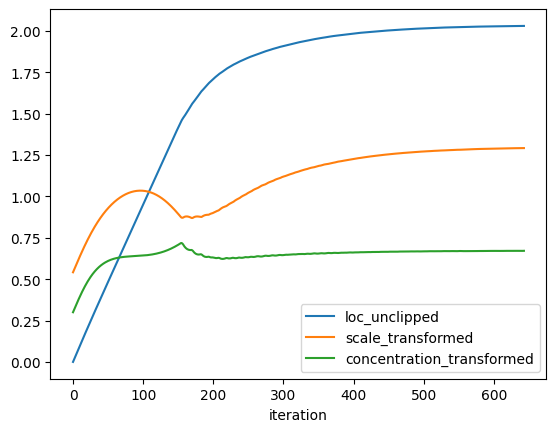

In [18]:
history_to_df(result.history)[["loc_unclipped", "scale_transformed", "concentration_transformed", "iteration"]].plot("iteration")

In [19]:
result.model_state["scale_value"].value

Array(1.5336367, dtype=float32)

Training loss: 22196.486, Validation loss: 22196.486:  64%|██████▍   | 643/999 [00:20<00:02, 171.11it/s]